In [35]:
import os
os.environ["OMP_NUM_THREADS"] = "4"  # Further reduce parallel processing issues


import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Step 1: Load & Preprocess Data
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)
    df.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
    df["eksd"] = pd.to_datetime(df["eksd"])
    df = df.sort_values(by=["pnr", "eksd"])
    print("✅ Data loaded and preprocessed.")
    return df

df = load_and_preprocess("ATC_med_events.csv")

✅ Data loaded and preprocessed.


In [29]:
# Step 2: Compute Event Intervals
def compute_event_intervals(df):
    df["prev_eksd"] = df.groupby("pnr")["eksd"].shift(1)
    df["event_interval"] = (df["eksd"] - df["prev_eksd"]).dt.days
    df = df.dropna()
    print("✅ Event intervals computed.")
    return df

df = compute_event_intervals(df)

# Step 3: Generate ECDF & Retain 80%
def retain_lower_ecdf(df, threshold=0.8):
    ecdf = sm.distributions.ECDF(df["event_interval"])
    df["ecdf"] = ecdf(df["event_interval"])
    df = df[df["ecdf"] <= threshold]
    print("✅ Retained lower 80% of ECDF.")
    return df

df = retain_lower_ecdf(df)

✅ Event intervals computed.
✅ Retained lower 80% of ECDF.


✅ Data loaded and preprocessed.
✅ Event intervals computed.
✅ Retained lower 80% of ECDF.


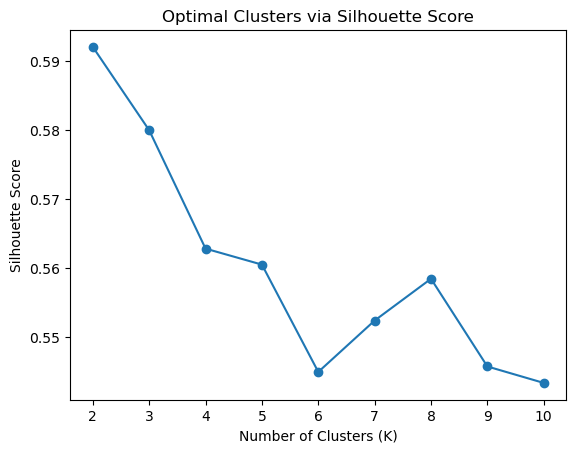

✅ Optimal K: 2
✅ K-Means clustering applied.
✅ DBSCAN clustering applied.
Silhouette Score - K-Means: 0.592
Silhouette Score - DBSCAN: N/A


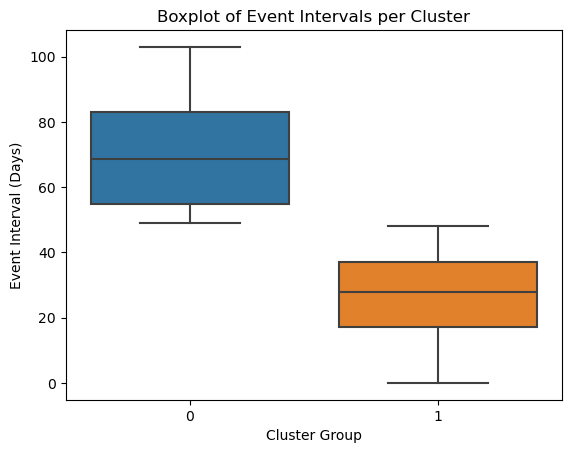

✅ Processed data exported as processed_ATC_med_events.csv


In [37]:
# ==============================================
# 🔹 Step 1: Setup Environment & Imports
# ==============================================
import os
import warnings
from threadpoolctl import threadpool_limits  # Fix for MKL & OpenMP threading

# Prevent KMeans memory leak by limiting threads
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import statsmodels.api as sm

warnings.filterwarnings("ignore", category=UserWarning)  # Suppress warnings

# ==============================================
# 🔹 Step 2: Load & Preprocess Data
# ==============================================
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)
    df.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
    df["eksd"] = pd.to_datetime(df["eksd"])
    df = df.sort_values(by=["pnr", "eksd"])
    print("✅ Data loaded and preprocessed.")
    return df

df = load_and_preprocess("ATC_med_events.csv")

# ==============================================
# 🔹 Step 3: Compute Event Intervals
# ==============================================
def compute_event_intervals(df):
    df["prev_eksd"] = df.groupby("pnr")["eksd"].shift(1)
    df["event_interval"] = (df["eksd"] - df["prev_eksd"]).dt.days
    df = df.dropna()
    print("✅ Event intervals computed.")
    return df

df = compute_event_intervals(df)

# ==============================================
# 🔹 Step 4: Generate ECDF & Retain 80%
# ==============================================
def retain_lower_ecdf(df, threshold=0.8):
    ecdf = sm.distributions.ECDF(df["event_interval"])
    df["ecdf"] = ecdf(df["event_interval"])
    df = df[df["ecdf"] <= threshold]
    print("✅ Retained lower 80% of ECDF.")
    return df

df = retain_lower_ecdf(df)

# ==============================================
# 🔹 Step 5: Determine Optimal K for K-Means
# ==============================================
def find_optimal_clusters(df, max_clusters=10):
    if df.empty:
        print("❌ No data available for clustering.")
        return None
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[["event_interval"]])
    scores = []
    
    for k in range(2, max_clusters + 1):
        with threadpool_limits(limits=1, user_api="blas"):  # Prevents memory leak
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(scaled_data)
            score = silhouette_score(scaled_data, labels)
            scores.append(score)
    
    plt.plot(range(2, max_clusters + 1), scores, marker="o")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.title("Optimal Clusters via Silhouette Score")
    plt.show()
    
    best_k = scores.index(max(scores)) + 2
    print(f"✅ Optimal K: {best_k}")
    return best_k

best_k = find_optimal_clusters(df)

# ==============================================
# 🔹 Step 6: Apply K-Means Clustering
# ==============================================
def apply_kmeans(df, num_clusters):
    if num_clusters is None:
        print("❌ K-Means skipped due to missing optimal cluster count.")
        return df

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[["event_interval"]])
    
    with threadpool_limits(limits=1, user_api="blas"):  # Prevents memory leak
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        df["KMeans_Cluster"] = kmeans.fit_predict(scaled_data)

    print("✅ K-Means clustering applied.")
    return df

df = apply_kmeans(df, best_k)

# ==============================================
# 🔹 Step 7: Apply DBSCAN Clustering
# ==============================================
def apply_dbscan(df, eps=0.5, min_samples=5):
    if df.empty:
        print("❌ No data available for DBSCAN clustering.")
        return df
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[["event_interval"]])
    
    with threadpool_limits(limits=1, user_api="blas"):  # Prevents memory leak
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        df["DBSCAN_Cluster"] = dbscan.fit_predict(scaled_data)

    print("✅ DBSCAN clustering applied.")
    return df

df = apply_dbscan(df)

# ==============================================
# 🔹 Step 8: Compare Clustering Methods
# ==============================================
def compare_clustering(df):
    if "KMeans_Cluster" not in df.columns or "DBSCAN_Cluster" not in df.columns:
        print("❌ Clustering comparison skipped due to missing results.")
        return
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[["event_interval"]])
    
    kmeans_score = silhouette_score(scaled_data, df["KMeans_Cluster"])
    dbscan_score = silhouette_score(scaled_data, df["DBSCAN_Cluster"]) if len(set(df["DBSCAN_Cluster"])) > 1 else "N/A"
    
    print(f"Silhouette Score - K-Means: {kmeans_score:.3f}")
    print(f"Silhouette Score - DBSCAN: {dbscan_score}")
    
    return {"K-Means": kmeans_score, "DBSCAN": dbscan_score}

compare_clustering(df)

# ==============================================
# 🔹 Step 9: Visualization (Boxplot)
# ==============================================
def plot_boxplot(df):
    if "KMeans_Cluster" not in df.columns:
        print("❌ Boxplot skipped due to missing clustering results.")
        return
    
    sns.boxplot(x="KMeans_Cluster", y="event_interval", data=df)
    plt.xlabel("Cluster Group")
    plt.ylabel("Event Interval (Days)")
    plt.title("Boxplot of Event Intervals per Cluster")
    plt.show()

plot_boxplot(df)

# ==============================================
# 🔹 Step 10: Export Processed Dataset
# ==============================================
def export_processed_data(df, file_name="processed_ATC_med_events.csv"):
    df.to_csv(file_name, index=False)
    print(f"✅ Processed data exported as {file_name}")

export_processed_data(df)
